In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

print("🚀 Starting Fraud Detection Analysis")
print(f"TensorFlow version: {tf.__version__}")

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# ================================
# STEP 1: DATA LOADING & INITIAL EXPLORATION
# ================================

# Load the dataset
try:
    # Try to load from multiple possible locations
    df = pd.read_csv('../data/fraud_data.csv')
    print("✅ Dataset loaded successfully!")
except:
    try:
        df = pd.read_csv('../data/PS_20174392719_1491204439457_log.csv')  # Original dataset name
        print(" Dataset loaded successfully!")
    except:
        print(" Dataset not found. Please ensure you have the fraud dataset in data/ folder")
        print("You can download it from: https://www.kaggle.com/datasets/jainilcoder/online-payment-fraud-detection")
        
        # Create sample data for demonstration
        print(" Creating sample dataset for demonstration...")
        np.random.seed(42)
        n_samples = 10000
        
        df = pd.DataFrame({
            'step': np.random.randint(1, 744, n_samples),
            'type': np.random.choice(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'], n_samples),
            'amount': np.random.exponential(100000, n_samples),
            'nameOrig': [f'C{i}' for i in range(n_samples)],
            'oldbalanceOrg': np.random.exponential(50000, n_samples),
            'newbalanceOrig': np.random.exponential(50000, n_samples),
            'nameDest': [f'M{i}' for i in range(n_samples)],
            'oldbalanceDest': np.random.exponential(50000, n_samples),
            'newbalanceDest': np.random.exponential(50000, n_samples),
            'isFraud': np.random.choice([0, 1], n_samples, p=[0.998, 0.002]),  # 0.2% fraud rate
            'isFlaggedFraud': np.random.choice([0, 1], n_samples, p=[0.999, 0.001])
        })

✅ Dataset loaded successfully!


In [3]:
print(f" Dataset shape: {df.shape}")
print("\n Dataset info:")
print(df.info())

print("\n First few rows:")
print(df.head())

print("\n Basic statistics:")
print(df.describe())


 Dataset shape: (6362620, 11)

 Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None

 First few rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4 


🔍 EXPLORATORY DATA ANALYSIS

❓ Missing values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

🚨 Fraud Distribution:
Total transactions: 6,362,620
Fraudulent: 8,213 (0.129%)
Legitimate: 6,354,407 (99.871%)


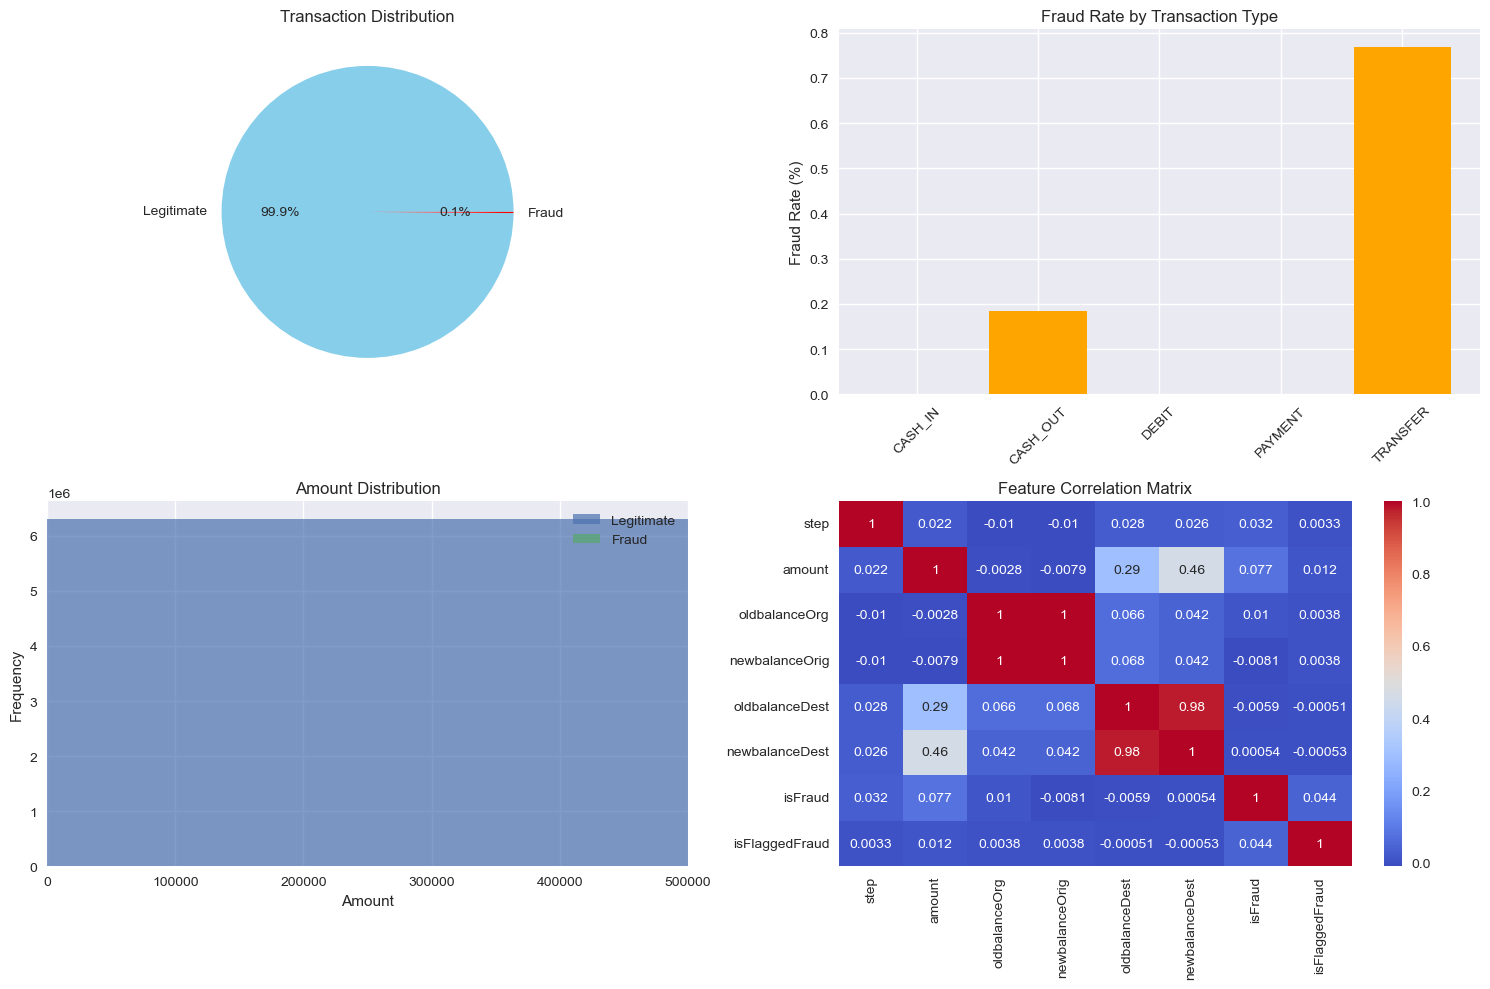


📊 Fraud by Transaction Type:
    type  sum  fraud_rate
 CASH_IN    0    0.000000
CASH_OUT 4116    0.183955
   DEBIT    0    0.000000
 PAYMENT    0    0.000000
TRANSFER 4097    0.768799


In [4]:
# ================================
# STEP 2: EXPLORATORY DATA ANALYSIS (EDA)
# ================================

print("\n" + "="*50)
print("🔍 EXPLORATORY DATA ANALYSIS")
print("="*50)

# Check for missing values
print("\n❓ Missing values:")
print(df.isnull().sum())

# Fraud distribution
fraud_counts = df['isFraud'].value_counts()
fraud_percentage = df['isFraud'].mean() * 100

print(f"\n🚨 Fraud Distribution:")
print(f"Total transactions: {len(df):,}")
print(f"Fraudulent: {fraud_counts[1]:,} ({fraud_percentage:.3f}%)")
print(f"Legitimate: {fraud_counts[0]:,} ({100-fraud_percentage:.3f}%)")

# Visualization setup
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Fraud distribution
axes[0,0].pie(fraud_counts.values, labels=['Legitimate', 'Fraud'], autopct='%1.1f%%', colors=['skyblue', 'red'])
axes[0,0].set_title('Transaction Distribution')

# 2. Fraud by transaction type
fraud_by_type = df.groupby('type')['isFraud'].agg(['sum', 'count', 'mean']).reset_index()
fraud_by_type['fraud_rate'] = fraud_by_type['mean'] * 100

axes[0,1].bar(fraud_by_type['type'], fraud_by_type['fraud_rate'], color='orange')
axes[0,1].set_title('Fraud Rate by Transaction Type')
axes[0,1].set_ylabel('Fraud Rate (%)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Amount distribution
df[df['isFraud']==0]['amount'].hist(bins=50, alpha=0.7, label='Legitimate', ax=axes[1,0])
df[df['isFraud']==1]['amount'].hist(bins=50, alpha=0.7, label='Fraud', ax=axes[1,0])
axes[1,0].set_title('Amount Distribution')
axes[1,0].set_xlabel('Amount')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()
axes[1,0].set_xlim(0, 500000)

# 4. Correlation heatmap
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

print(f"\n📊 Fraud by Transaction Type:")
print(fraud_by_type[['type', 'sum', 'fraud_rate']].to_string(index=False))

In [5]:
# ================================
# STEP 3: DATA PREPROCESSING
# ================================

print("\n" + "="*50)
print("🔧 DATA PREPROCESSING")
print("="*50)

# Create a copy for preprocessing
df_processed = df.copy()

# Remove irrelevant features (high cardinality, low impact)
columns_to_drop = ['nameOrig', 'nameDest']
df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')

print(f"✅ Removed columns: {columns_to_drop}")

# Feature Engineering
print("\n🔨 Feature Engineering:")

# 1. Balance differences
df_processed['balance_diff_orig'] = df_processed['oldbalanceOrg'] - df_processed['newbalanceOrig']
df_processed['balance_diff_dest'] = df_processed['newbalanceDest'] - df_processed['oldbalanceDest']

print("✅ Created balance difference features")

# 2. One-hot encoding for transaction type
type_dummies = pd.get_dummies(df_processed['type'], prefix='type')
df_processed = pd.concat([df_processed, type_dummies], axis=1)
df_processed = df_processed.drop('type', axis=1)

print("✅ Applied one-hot encoding for transaction types")

# 3. Handle target variable
X = df_processed.drop(['isFraud'], axis=1)
y = df_processed['isFraud']

print(f"\n📊 Features shape: {X.shape}")
print(f"📊 Target shape: {y.shape}")
print(f"📊 Feature columns: {list(X.columns)}")

# 4. Scale numerical features
scaler = StandardScaler()
numerical_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                     'oldbalanceDest', 'newbalanceDest', 'balance_diff_orig', 'balance_diff_dest']

# Only scale features that exist in our dataset
numerical_features = [col for col in numerical_features if col in X.columns]
X[numerical_features] = scaler.fit_transform(X[numerical_features])

print("✅ Scaled numerical features")


🔧 DATA PREPROCESSING
✅ Removed columns: ['nameOrig', 'nameDest']

🔨 Feature Engineering:
✅ Created balance difference features
✅ Applied one-hot encoding for transaction types

📊 Features shape: (6362620, 14)
📊 Target shape: (6362620,)
📊 Feature columns: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'balance_diff_orig', 'balance_diff_dest', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
✅ Scaled numerical features


In [6]:
# ================================
# STEP 4: HANDLE CLASS IMBALANCE
# ================================

print("\n" + "="*50)
print("⚖️ HANDLING CLASS IMBALANCE")
print("="*50)

# Split data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"📊 Training set shape: {X_train.shape}")
print(f"📊 Test set shape: {X_test.shape}")

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\n🔄 After SMOTE:")
print(f"📊 Balanced training set shape: {X_train_balanced.shape}")
print(f"📊 Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


⚖️ HANDLING CLASS IMBALANCE
📊 Training set shape: (5090096, 14)
📊 Test set shape: (1272524, 14)

🔄 After SMOTE:
📊 Balanced training set shape: (10167052, 14)
📊 Class distribution after SMOTE:
isFraud
0    5083526
1    5083526
Name: count, dtype: int64


In [7]:
# ================================
# STEP 5: BUILD DEEP NEURAL NETWORK
# ================================

print("\n" + "="*50)
print("🧠 BUILDING DEEP NEURAL NETWORK")
print("="*50)

# Model architecture based on the original research
model = Sequential([
    Dense(128, input_dim=X_train_balanced.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✅ Model architecture:")
model.summary()


🧠 BUILDING DEEP NEURAL NETWORK


NameError: name 'Sequential' is not defined

In [24]:
# ================================
# STEP 6: TRAIN THE MODEL
# ================================

print("\n" + "="*50)
print("🏋️ TRAINING THE MODEL")
print("="*50)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Calculate class weights for additional balance
class_weights = {
    0: 1.0,
    1: len(y_train_balanced[y_train_balanced==0]) / len(y_train_balanced[y_train_balanced==1])
}

print(f"📊 Class weights: {class_weights}")

# Train the model
history = model.fit(
    X_train_balanced, y_train_balanced,
    epochs=50,
    batch_size=512,
    
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights,
    verbose=1
)

print("✅ Model training completed!")


🏋️ TRAINING THE MODEL


NameError: name 'EarlyStopping' is not defined

In [ ]:
# ================================
# STEP 7: MODEL EVALUATION
# ================================

print("\n" + "="*50)
print("📊 MODEL EVALUATION")
print("="*50)

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Detailed classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n🔍 Confusion Matrix:")
print(f"[[{cm[0,0]:6} {cm[0,1]:6}]")
print(f" [{cm[1,0]:6} {cm[1,1]:6}]]")

print(f"\nExplanation:")
print(f"True Negatives (TN): {cm[0,0]:,} - Legitimate correctly identified")
print(f"False Positives (FP): {cm[0,1]:,} - Legitimate incorrectly flagged as fraud")
print(f"False Negatives (FN): {cm[1,0]:,} - Fraud missed by model")
print(f"True Positives (TP): {cm[1,1]:,} - Fraud correctly detected")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()